In [1]:
import os
import numpy as np
import nibabel as nib

def calculate_brain_bounds(data_path, subject_ids, output_path):
    xx_min_list = []
    xx_max_list = []
    yy_min_list = []
    yy_max_list = []

    for subject_id in subject_ids:
        mask_path = os.path.join(data_path, subject_id, 'nodif_brain_mask.nii.gz')
        if not os.path.exists(mask_path):
            print(f"Mask file not found for subject {subject_id}. Skipping.")
            continue

        mask_img = nib.load(mask_path)
        mask_data = mask_img.get_fdata()

        # 获取脑掩码的非零坐标
        non_zero = np.argwhere(mask_data > 0)
        if non_zero.size == 0:
            print(f"No brain region found in mask for subject {subject_id}. Skipping.")
            continue

        # 分别获取x和y轴的最小和最大坐标
        xx_min = non_zero[:, 1].min()
        xx_max = non_zero[:, 1].max()
        yy_min = non_zero[:, 2].min()
        yy_max = non_zero[:, 2].max()

        xx_min_list.append(xx_min)
        xx_max_list.append(xx_max)
        yy_min_list.append(yy_min)
        yy_max_list.append(yy_max)

        print(f"Subject {subject_id}: xx_min={xx_min}, xx_max={xx_max}, yy_min={yy_min}, yy_max={yy_max}")

    # 计算所有主体的整体最小和最大坐标
    overall_xx_min = int(min(xx_min_list))
    overall_xx_max = int(max(xx_max_list))
    overall_yy_min = int(min(yy_min_list))
    overall_yy_max = int(max(yy_max_list))

    print(f"Overall Brain Bounds: xx_min={overall_xx_min}, xx_max={overall_xx_max}, yy_min={overall_yy_min}, yy_max={overall_yy_max}")

    # 保存为 .npy 文件
    brain_bounds = np.array([overall_xx_min, overall_xx_max, overall_yy_min, overall_yy_max])
    np.save(output_path, brain_bounds)
    print(f"Saved brain_max_lenght.npy successfully at {output_path}")

def main():
    data_path = '/data2/mayupeng/HCP_25_dataset_60'
    subject_ids = [ "102816", "103010", "103111", "103212", "103414"
    
        # 添加所有您的主体ID
    ]
    output_path = '/data2/mayupeng/chen/hcp_brain_max_lenght.npy'

    calculate_brain_bounds(data_path, subject_ids, output_path)

if __name__ == '__main__':
    main()


Subject 102816: xx_min=20, xx_max=159, yy_min=6, yy_max=111
Subject 103010: xx_min=17, xx_max=164, yy_min=9, yy_max=118
Subject 103111: xx_min=9, xx_max=163, yy_min=7, yy_max=120
Subject 103212: xx_min=12, xx_max=160, yy_min=9, yy_max=116
Subject 103414: xx_min=18, xx_max=156, yy_min=9, yy_max=112
Overall Brain Bounds: xx_min=9, xx_max=164, yy_min=6, yy_max=120
Saved brain_max_lenght.npy successfully at /data2/mayupeng/chen/hcp_brain_max_lenght.npy


In [2]:
import os
import numpy as np
import nibabel as nib
import shutil

def convert_subject_data(subject_id, original_data_path, new_data_path):
    subject_original_path = os.path.join(original_data_path, subject_id)
    subject_new_path = os.path.join(new_data_path, subject_id)
    os.makedirs(subject_new_path, exist_ok=True)
    
    # 读取输入数据（data_fi.nii.gz），并提取前30个图像（b=1000）
    data_fi_path = os.path.join(subject_original_path, 'data_fi.nii.gz')
    if not os.path.exists(data_fi_path):
        print(f"{data_fi_path} does not exist.")
        return
    data_fi_img = nib.load(data_fi_path)
    data_fi_data = data_fi_img.get_fdata()
    
    # 检查data_fi_data的维度，确保第四维度存在
    if data_fi_data.ndim < 4 or data_fi_data.shape[3] < 30:
        print(f"{data_fi_path} does not have enough volumes.")
        return
    # 提取前30个图像（b=1000）
    input_data = data_fi_data[..., :30]
    # 保存为 .npy 文件
    input_npy_path = os.path.join(subject_new_path, 'train_ght_data_30_NODDI.npy')
    np.save(input_npy_path, input_data)
    print(f"Saved input data to {input_npy_path}")
    
    # 读取真实值数据（FIT_ICVF.nii.gz, FIT_ISOVF.nii.gz, FIT_OD.nii.gz）
    noddi_path = os.path.join(subject_original_path, 'NODDI')
    icvf_path = os.path.join(noddi_path, 'FIT_ICVF.nii.gz')
    isovf_path = os.path.join(noddi_path, 'FIT_ISOVF.nii.gz')
    od_path = os.path.join(noddi_path, 'FIT_OD.nii.gz')
    if not os.path.exists(icvf_path) or not os.path.exists(isovf_path) or not os.path.exists(od_path):
        print(f"One or more NODDI parameter files are missing for subject {subject_id}.")
        return
    icvf_img = nib.load(icvf_path)
    isovf_img = nib.load(isovf_path)
    od_img = nib.load(od_path)
    icvf_data = icvf_img.get_fdata()
    isovf_data = isovf_img.get_fdata()
    od_data = od_img.get_fdata()
    
    # 确保真实值数据的形状一致
    if icvf_data.shape != isovf_data.shape or icvf_data.shape != od_data.shape:
        print(f"NODDI parameter files have inconsistent shapes for subject {subject_id}.")
        return
    # 合并三个参数到一个数组，最后一个维度为参数数目（3）
    gt_data = np.stack([icvf_data, isovf_data, od_data], axis=-1)
    # 保存为 .npy 文件
    gt_npy_path = os.path.join(subject_new_path, 'train_gt_ght_data_30_NODDI.npy')
    np.save(gt_npy_path, gt_data)
    print(f"Saved ground truth data to {gt_npy_path}")
    
    # 复制掩码文件
    mask_original_path = os.path.join(subject_original_path, 'nodif_brain_mask.nii.gz')
    mask_new_path = os.path.join(subject_new_path, 'nodif_brain_mask.nii.gz')
    if not os.path.exists(mask_original_path):
        print(f"Mask file is missing for subject {subject_id}.")
        return
    if not os.path.exists(mask_new_path):
        shutil.copy(mask_original_path, mask_new_path)
    print(f"Copied mask file to {mask_new_path}")
    
    # 复制 b1000_30.txt 文件（梯度方向）为 bvecs
    bvecs_original_path = os.path.join(subject_original_path, 'b1000_30.txt')
    bvecs_new_path = os.path.join(subject_new_path, 'bvecs')
    if not os.path.exists(bvecs_original_path):
        print(f"bvecs file is missing for subject {subject_id}.")
        return
    if not os.path.exists(bvecs_new_path):
        shutil.copy(bvecs_original_path, bvecs_new_path)
    print(f"Copied bvecs file to {bvecs_new_path}")
    
    # 生成 bvals 文件，全部为1000，长度为30
    bvals = [1000] * 30
    bvals_new_path = os.path.join(subject_new_path, 'bvals')
    if not os.path.exists(bvals_new_path):
        np.savetxt(bvals_new_path, bvals, fmt='%d', newline=' ')
    print(f"Saved bvals to {bvals_new_path}")

def main():
    original_data_path = '/data2/mayupeng/HCP_25_dataset_ori'
    new_data_path = '/data2/mayupeng/HCP_25_dataset_30'
    subject_ids = [
    "100206", "100307", "100408", "100610", "101006",
    "101107", "101309", "101410", "101915", "102008",
    "102109", "102311", "102513", "102614", "102715",
    "102816", "103010", "103111", "103212", "103414",
    "103515", "103818", "104012", "104416", "104820"
        # 添加所有您的主体ID
    ]
    
    os.makedirs(new_data_path, exist_ok=True)
    
    for subject_id in subject_ids:
        print(f"Processing subject {subject_id}")
        convert_subject_data(subject_id, original_data_path, new_data_path)
    
    print("Data conversion completed.")

if __name__ == '__main__':
    main()


Processing subject 100206
Saved input data to /data2/mayupeng/HCP_25_dataset_30/100206/train_ght_data_30_NODDI.npy
Saved ground truth data to /data2/mayupeng/HCP_25_dataset_30/100206/train_gt_ght_data_30_NODDI.npy
Copied mask file to /data2/mayupeng/HCP_25_dataset_30/100206/nodif_brain_mask.nii.gz
Copied bvecs file to /data2/mayupeng/HCP_25_dataset_30/100206/bvecs
Saved bvals to /data2/mayupeng/HCP_25_dataset_30/100206/bvals
Processing subject 100307
Saved input data to /data2/mayupeng/HCP_25_dataset_30/100307/train_ght_data_30_NODDI.npy
Saved ground truth data to /data2/mayupeng/HCP_25_dataset_30/100307/train_gt_ght_data_30_NODDI.npy
Copied mask file to /data2/mayupeng/HCP_25_dataset_30/100307/nodif_brain_mask.nii.gz
Copied bvecs file to /data2/mayupeng/HCP_25_dataset_30/100307/bvecs
Saved bvals to /data2/mayupeng/HCP_25_dataset_30/100307/bvals
Processing subject 100408
Saved input data to /data2/mayupeng/HCP_25_dataset_30/100408/train_ght_data_30_NODDI.npy
Saved ground truth data to 

KeyboardInterrupt: 

加载医学图像类型为<class 'nibabel.nifti1.Nifti1Image'>
浮点图像数据类型为<class 'numpy.ndarray'>
图像数据形状为(145, 174, 145)
0.49148568511009216


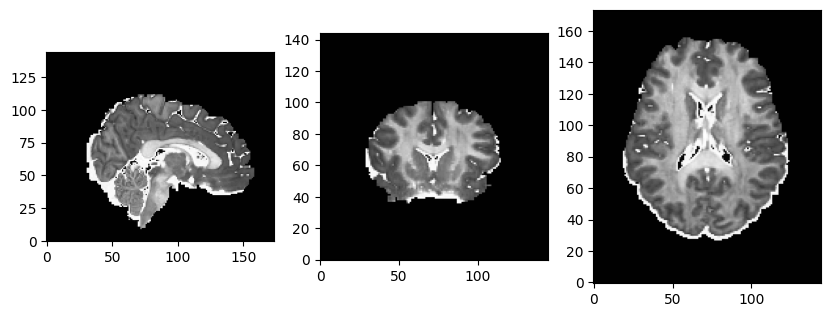

In [1]:
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np


epi_index = nib.load(
    r"/data2/mayupeng/chen/rank_image/102816_pred_c0.nii.gz"
)
print("加载医学图像类型为{}".format(type(epi_index)))
epi_index_data = epi_index.get_fdata()
print("浮点图像数据类型为{}".format(type(epi_index_data)))
print("图像数据形状为{}".format(epi_index_data.shape))
def show_slices(slices):
    """Function to display row of image slices"""
    fig, axes = plt.subplots(1, len(slices))
    fig.set_size_inches(10,5)
    for i, slice in enumerate(slices):
        axes[i].imshow(slice.T, cmap="gray", origin="lower")

slice_0 = epi_index_data[70, :, :]
slice_1 = epi_index_data[:, 120, :]
slice_2 = epi_index_data[:, :, 70]
show_slices([slice_0, slice_1, slice_2])
print(epi_index_data[50, 50,70])

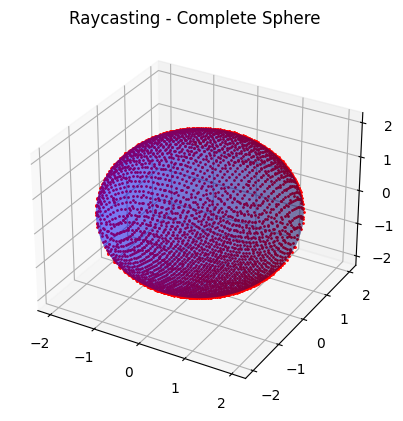

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 定义射线与球体的交点计算函数
def ray_sphere_intersection(ray_origin, ray_direction, sphere_center, sphere_radius):
    # 计算射线起点到球心的向量
    L = sphere_center - ray_origin
    # 计算射线与球心的投影
    tca = np.dot(L, ray_direction)
    # 计算射线与球心的距离的平方
    d2 = np.dot(L, L) - tca**2
    r2 = sphere_radius**2
    # 如果射线与球体不相交，返回空
    if d2 > r2:
        return None
    # 计算交点的距离
    thc = np.sqrt(r2 - d2)
    t0 = tca - thc
    t1 = tca + thc
    # 返回两点的参数值
    return t0, t1

# 定义绘制球体的函数
def render_sphere(ray_origin, sphere_center, sphere_radius, angle_range=180, num_rays=360):
    # 生成 3D 坐标系
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # 绘制球体表面
    u = np.linspace(0, 2 * np.pi, 100)
    v = np.linspace(0, np.pi, 50)
    x = sphere_center[0] + sphere_radius * np.outer(np.cos(u), np.sin(v))
    y = sphere_center[1] + sphere_radius * np.outer(np.sin(u), np.sin(v))
    z = sphere_center[2] + sphere_radius * np.outer(np.ones(np.size(u)), np.cos(v))
    ax.plot_surface(x, y, z, color='b', alpha=0.3)

    # 使用 Raycasting 绘制球体
    for azimuth in np.linspace(0, 2 * np.pi, num_rays):  # 绕 Y 轴旋转
        for elevation in np.linspace(0, np.pi, num_rays):  # 绕 X 轴旋转
            # 计算射线的方向
            ray_direction = np.array([
                np.cos(elevation) * np.sin(azimuth),
                np.sin(elevation),
                np.cos(elevation) * np.cos(azimuth)
            ])
            # 计算射线与球体的交点
            intersection = ray_sphere_intersection(ray_origin, ray_direction, sphere_center, sphere_radius)
            if intersection:
                t0, t1 = intersection
                # 计算射线与球体的交点坐标
                p0 = ray_origin + t0 * ray_direction
                p1 = ray_origin + t1 * ray_direction
                # 绘制交点
                ax.scatter(p0[0], p0[1], p0[2], color='r', s=1)
                ax.scatter(p1[0], p1[1], p1[2], color='r', s=1)

    # 设置图形的标题和坐标轴标签
    ax.set_title('Raycasting - Complete Sphere')
    plt.show()

# 定义摄像机位置和球体参数
ray_origin = np.array([0, 0, -10])  # 摄像机位置（视点）
sphere_center = np.array([0, 0, 0])  # 球体中心
sphere_radius = 2  # 球体半径

# 渲染球体
render_sphere(ray_origin, sphere_center, sphere_radius)


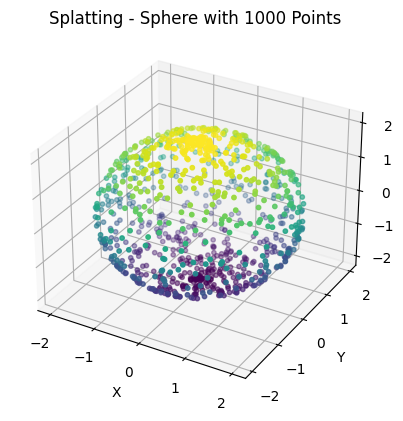

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 生成球体的点云数据
def generate_sphere_points(radius, num_points=1000):
    # 随机生成球面上的点
    phi = np.random.uniform(0, np.pi, num_points)  # 俯仰角
    theta = np.random.uniform(0, 2 * np.pi, num_points)  # 方位角
    x = radius * np.sin(phi) * np.cos(theta)
    y = radius * np.sin(phi) * np.sin(theta)
    z = radius * np.cos(phi)
    return x, y, z

# 绘制球体
def render_sphere(radius=2, num_points=1000, splat_radius=0.1):
    # 生成球体点云
    x, y, z = generate_sphere_points(radius, num_points)

    # 创建一个 3D 图形
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # 绘制点云（splatting效果），通过调整点的大小来模拟splatting
    ax.scatter(x, y, z, c=z, cmap='viridis', marker='o', s=splat_radius * 100)

    # 设置标题和轴标签
    ax.set_title(f'Splatting - Sphere with {num_points} Points')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    # 显示图形
    plt.show()

# 调用函数，渲染球体
render_sphere(radius=2, num_points=1000, splat_radius=0.1)


In [11]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import torch
import torch.nn as nn
import scipy.stats.stats as stats
import numpy as np



class SpearmanLoss(torch.nn.Module):
    """Loss function  inspired by spearmann correlation.self
    Required the trained model to have a good initlization.

    Set lbd to 1 for a few epoch to help with the initialization.
    """

    def __init__(self, sorter_type, seq_len=None, sorter_state_dict=None, lbd=1):
        super(SpearmanLoss, self).__init__()
        self.sorter = model_loader(sorter_type, seq_len, sorter_state_dict)

        self.criterion_mse = torch.nn.MSELoss()
        self.criterionl1 = torch.nn.L1Loss()

        self.lbd = lbd

    def forward(self, mem_pred, mem_gt, pr=False):
        rank_gt = get_tiedrank(mem_gt)

        rank_pred = self.sorter(mem_pred.unsqueeze(0)).view(-1)

        return self.criterion_mse(rank_pred, rank_gt) + self.lbd * self.criterionl1(
            mem_pred, mem_gt
        )

def get_tiedrank(batch_score, dim=0):
    batch_score = batch_score.cpu()
    
    rank = stats.rankdata(batch_score)
    rank = stats.rankdata(rank) - 1
    rank = (rank * -1) + batch_score.size(dim)
    rank = torch.from_numpy(rank).cuda()
    rank = rank.float()
    rank = rank / batch_score.size(dim)
    return rank


def model_loader(model_type, seq_len, pretrained_state_dict=None):
    if model_type == "lstm":
        model = lstm_baseline(seq_len)
    elif model_type == "lstmla":
        model = lstm_large(seq_len)
    elif model_type == "lstme":
        model = lstm_end(seq_len)
    elif model_type == "mlp":
        model = mlp(seq_len)

    else:
        raise Exception("Model type unknown", model_type)

    if pretrained_state_dict is not None:
        model.load_state_dict(pretrained_state_dict)

    return model





class lstm_large(nn.Module):
    def __init__(self, seq_len):
        super(lstm_large, self).__init__()
        self.lstm = nn.LSTM(1, 512, 2, batch_first=True, bidirectional=True)
        self.conv1 = nn.Conv1d(seq_len, seq_len, 1024)

    def forward(self, input_):
        input_ = input_.reshape(input_.size(0), -1, 1)
        out, _ = self.lstm(input_)
        out = self.conv1(out)

        return out.view(input_.size(0), -1)
    

def load_sorter(checkpoint_path):
    sorter_checkpoint = torch.load(checkpoint_path)

    model_type = sorter_checkpoint["args_dict"].model_type
    seq_len = sorter_checkpoint["args_dict"].seq_len
    state_dict = sorter_checkpoint["state_dict"]

    return model_type, seq_len, state_dict  

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model_loader(*load_sorter(checkpoint_path="/data2/mayupeng/Loss/weights/real_model.pth.tar")).to(device) 
rand_data = torch.rand(64,1).to(device)

uniform_labels = torch.linspace(0, 1, steps=64).unsqueeze(-1).to(device)  # (64,1)
scaled_rand_data = rand_data * 10
scaled_uniform_labels = uniform_labels * 10                                 
mem_pred_enhanced = torch.cat([scaled_rand_data, scaled_uniform_labels], dim=0)  # (128, 1)
mem_gt_enhanced = torch.cat([scaled_rand_data, scaled_uniform_labels], dim=0)  # (128, 1)

print(mem_pred_enhanced.shape)
print(mem_gt_enhanced.shape)

rank_gt = get_tiedrank(mem_gt_enhanced)
print(rank_gt.shape)

rank_pred = model(mem_pred_enhanced.unsqueeze(0))
print(rank_pred.shape)

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128])
torch.Size([1, 128])


/tmp/ipykernel_95946/3408393456.py:38: DeprecationWarning: Please use `rankdata` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  rank = stats.rankdata(batch_score)
/tmp/ipykernel_95946/3408393456.py:39: DeprecationWarning: Please use `rankdata` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  rank = stats.rankdata(rank) - 1


In [10]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import torch
import torch.nn as nn
import scipy.stats.stats as stats
import numpy as np



class SpearmanLoss(torch.nn.Module):
    """Loss function  inspired by spearmann correlation.self
    Required the trained model to have a good initlization.

    Set lbd to 1 for a few epoch to help with the initialization.
    """

    def __init__(self, sorter_type, seq_len=None, sorter_state_dict=None, lbd=1):
        super(SpearmanLoss, self).__init__()
        self.sorter = model_loader(sorter_type, seq_len, sorter_state_dict)

        self.criterion_mse = torch.nn.MSELoss()
        self.criterionl1 = torch.nn.L1Loss()

        self.lbd = lbd

    def forward(self, mem_pred, mem_gt, pr=False):
        rank_gt = get_rank(mem_gt)

        rank_pred = self.sorter(mem_pred)

        return self.criterion_mse(rank_pred, rank_gt) + self.lbd * self.criterionl1(
            mem_pred, mem_gt
        )

def get_rank(batch_score, dim=1):
    rank = torch.argsort(batch_score, dim=dim)
    rank = torch.argsort(rank, dim=dim)
    rank = (rank * -1) + batch_score.size(dim)
    rank = rank.float()
    rank = rank / batch_score.size(dim)

    return rank


def model_loader(model_type, seq_len, pretrained_state_dict=None):
    if model_type == "lstm":
        model = lstm_baseline(seq_len)
    elif model_type == "lstmla":
        model = lstm_large(seq_len)
    elif model_type == "lstme":
        model = lstm_end(seq_len)
    elif model_type == "mlp":
        model = mlp(seq_len)

    else:
        raise Exception("Model type unknown", model_type)

    if pretrained_state_dict is not None:
        model.load_state_dict(pretrained_state_dict)

    return model





class lstm_large(nn.Module):
    def __init__(self, seq_len):
        super(lstm_large, self).__init__()
        self.lstm = nn.LSTM(1, 512, 2, batch_first=True, bidirectional=True)
        self.conv1 = nn.Conv1d(seq_len, seq_len, 1024)

    def forward(self, input_):
        input_ = input_.reshape(input_.size(0), -1, 1)
        out, _ = self.lstm(input_)
        out = self.conv1(out)

        return out.view(input_.size(0), -1)
    

def load_sorter(checkpoint_path):
    sorter_checkpoint = torch.load(checkpoint_path)

    model_type = sorter_checkpoint["args_dict"].model_type
    seq_len = sorter_checkpoint["args_dict"].seq_len
    state_dict = sorter_checkpoint["state_dict"]

    return model_type, seq_len, state_dict  

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model_loader(*load_sorter(checkpoint_path="/data2/mayupeng/Loss/weights/real_model.pth.tar")).to(device) 
rand_data = torch.rand(64,128).to(device)


scaled_rand_data = rand_data * 10                             
mem_pred_enhanced = scaled_rand_data.unsqueeze(2)
mem_gt_enhanced = scaled_rand_data.unsqueeze(2)

print(mem_pred_enhanced.shape)
print(mem_gt_enhanced.shape)

rank_gt = get_rank(mem_gt_enhanced)
print(rank_gt.shape)

rank_pred = model(mem_pred_enhanced)
print(rank_pred.shape)

torch.Size([64, 128, 1])
torch.Size([64, 128, 1])
torch.Size([64, 128, 1])
torch.Size([64, 128])
